# Haystacks processing

### Load file and dependencies

In [1]:
from astropy.io import fits
import numpy as np

# import plotting library & parameters
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

# enable the following to use Times for the fonts
# plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rc('lines',linewidth=2)


Populating the interactive namespace from numpy and matplotlib


### This loads the file, but the data is not yet loaded

In [2]:
# you can work directly on the .fits.gz compressed file, although decompressing first can save some time
haystacks_file = 'modern_cube_zodi1inc0dist10_0.70-0.87um.fits'
haystacks = fits.open(haystacks_file)

### The image information is in the header of extension 0

In [3]:
cubehdr = haystacks[0].header
cubehdr

SIMPLE  =                    T / Written by IDL:  Tue Sep 19 21:25:35 2017      
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2017-09-20'         / Creation UTC (CCCC-MM-DD) date of FITS header  
SUN     =                    T / Sun in central pixel                           
LOCAL   =                    T / Local zodiacal background added                
COMMENT Spectral image cube of the Solar System.                                
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
BUNIT   = 'Jy      '           /Map units per pixel                             
INC     =              0.00000 /System inclination in degrees                   
ZODI    =              1.000

In [4]:
N_EXT = cubehdr['N_EXT']
print ("Number of extensions with data:",N_EXT)

('Number of extensions with data:', 64)


### The first extension with data is then extension 1

In [5]:
first_slice = haystacks[1].data
first_wavel = haystacks[1].header['WAVEL']
print ("Wavelength of first slice:", first_wavel," um")

('Wavelength of first slice:', 0.700566, ' um')


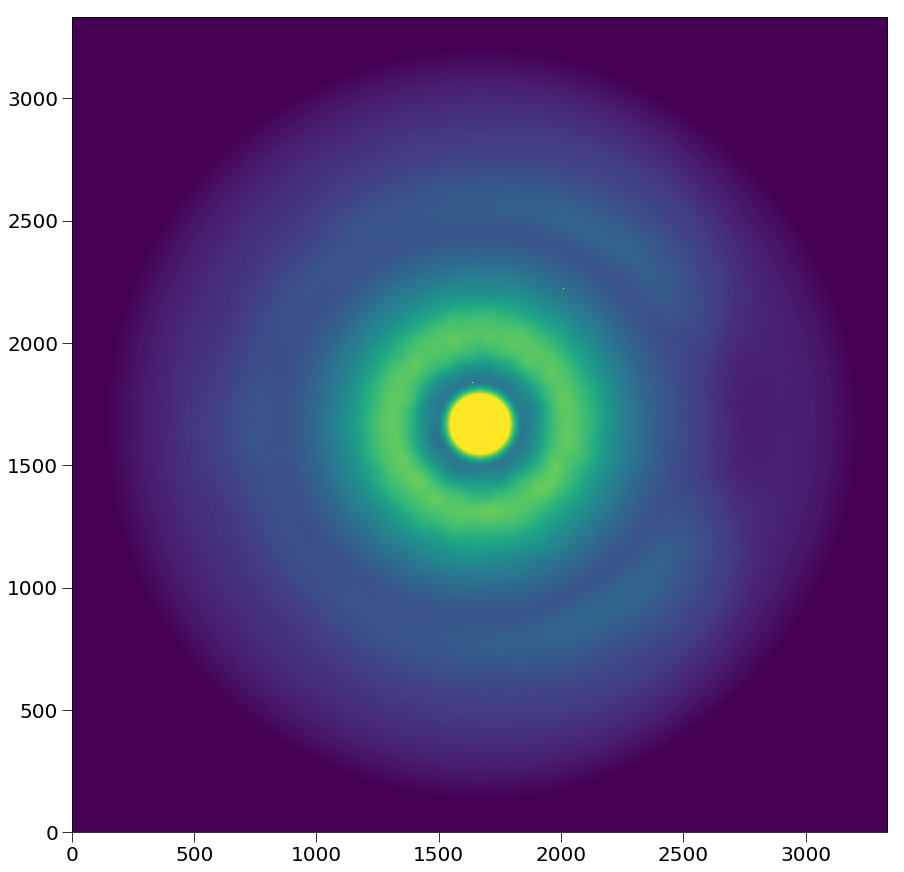

In [6]:
plt.figure(figsize=(15,15))
from matplotlib.colors import LogNorm
plt.imshow(first_slice,norm=LogNorm(vmin=2.2e-11,vmax=2.4e-11))

### The last slice is in extension N_EXT

In [7]:
last_slice = haystacks[N_EXT].data
last_wavel = haystacks[N_EXT].header['WAVEL']
print ("Wavelength of last slice:", last_wavel," um")

('Wavelength of last slice:', 0.865058, ' um')


### To assemble a single datacube in memory, just add the slices one by one

In [8]:
fullcube = np.zeros((N_EXT,first_slice.shape[0],first_slice.shape[1]),dtype=np.float32)
print (fullcube.shape)

(64, 3333, 3333)


In [9]:
# warning: this can take up a lot of memory! 
for i in range(N_EXT):
    fullcube[i] = haystacks[i+1].data

### Wavelengths are in extension N_EXT+1


In [10]:
wavlist = haystacks[N_EXT+1].data
print (wavlist)

[ 0.70056552  0.7031765   0.70578748  0.70839846  0.71100944  0.71362042
  0.71623141  0.71884239  0.72145337  0.72406441  0.72667539  0.72928637
  0.73189735  0.73450834  0.73711932  0.7397303   0.74234128  0.74495226
  0.74756324  0.75017422  0.75278521  0.75539619  0.75800717  0.76061815
  0.76322913  0.76584017  0.76845109  0.77106214  0.77367312  0.7762841
  0.77889508  0.78150606  0.78411704  0.78672802  0.78933901  0.79194999
  0.79456097  0.79717195  0.79978293  0.80239391  0.80500489  0.80761588
  0.81022692  0.81283784  0.81544888  0.81805986  0.82067084  0.82328182
  0.82589281  0.82850379  0.83111477  0.83372575  0.83633673  0.83894771
  0.84155869  0.84416968  0.84678066  0.84939164  0.85200262  0.85461366
  0.85722458  0.85983562  0.86244661  0.86505759]


### Stellar flux is in extension N_EXT+2

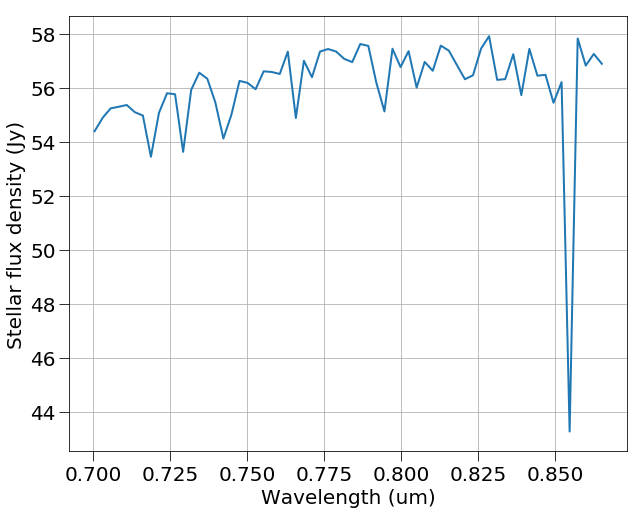

In [11]:
stellar = haystacks[N_EXT+2].data
plt.figure(figsize=(10,8))
plt.plot(wavlist,stellar)
plt.xlabel('Wavelength (um)')
plt.ylabel('Stellar flux density (Jy)')
plt.grid()

### Planet albedos are in extension N_EXT+3


('Number of planets is: ', 7)


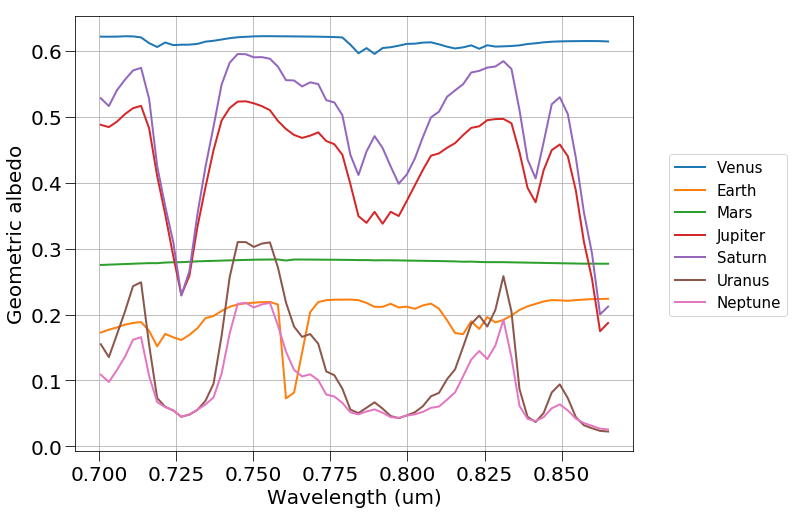

In [12]:
planetlist = ['Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
planets = haystacks[N_EXT+3].data
print ("Number of planets is: ",planets.shape[0])
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.plot(wavlist,planets[p],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Geometric albedo')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.7))
plt.grid()

### Planet parameters are in extension N_EXT+4

In [13]:
params = haystacks[N_EXT+4].data
# lists of parameters for all planets
# parameters are normalized with GM = 4pi**2
radii = params[0,:] # planet radius in AU
a = params[1,:]     # semi major axis in AU
ecc = params[2,:]     # Eccentricity
inc = params[3,:]     # inclination (radians)
longperi = params[4,:]     # Longitude of perihelion (radians)
longnode = params[5,:]     # Longitude of ascending node (radians)
meanlong = params[6,:]     # Mean longitude (radians)
argperi = params[7,:]      # Argument of perihelion (radians) (=meanlong-longperi)
periods = params[8,:]      # Orbital periods (years) (=a**1.5, where a is in AU; 1AU -> 1 year)
meananom = params[9,:]     # Mean anomaly (radians) (=argperi+2*pi*epoch/periods)
X = params[10,:]     # X coordinate of planet (in AU in the 3D scene)
Y = params[11,:]     # Y coordinate of planet (in AU in the 3D scene)
Z = params[12,:]     # Z coordinate of planet (in AU in the 3D scene)
Xpix = params[13,:]     # X location in cube (second dimension in Python arrays)
Ypix = params[14,:]     # Y location in cube (first dimension in Python arrays)
print (Xpix,Ypix)


(array([ 1655.,  1699.,  1633.,  1635.,  1974.,  2007.,  2667.]), array([ 1687.,  1666.,  1626.,  1836.,  1571.,  2219.,  1666.]))


### Extract planet observed spectra

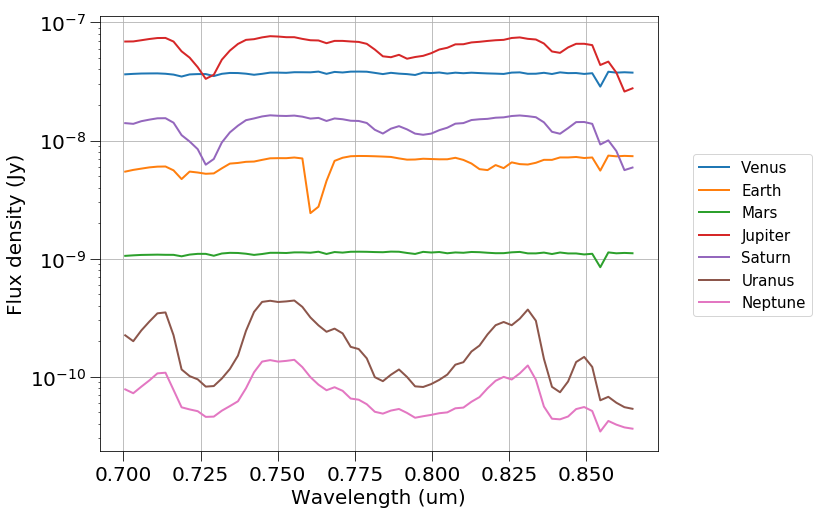

In [14]:
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.semilogy(wavlist,fullcube[:,int(Ypix[p]),int(Xpix[p])],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux density (Jy)')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.70))
plt.grid()

## Look at a Haystacks cube at 60 degree inclination

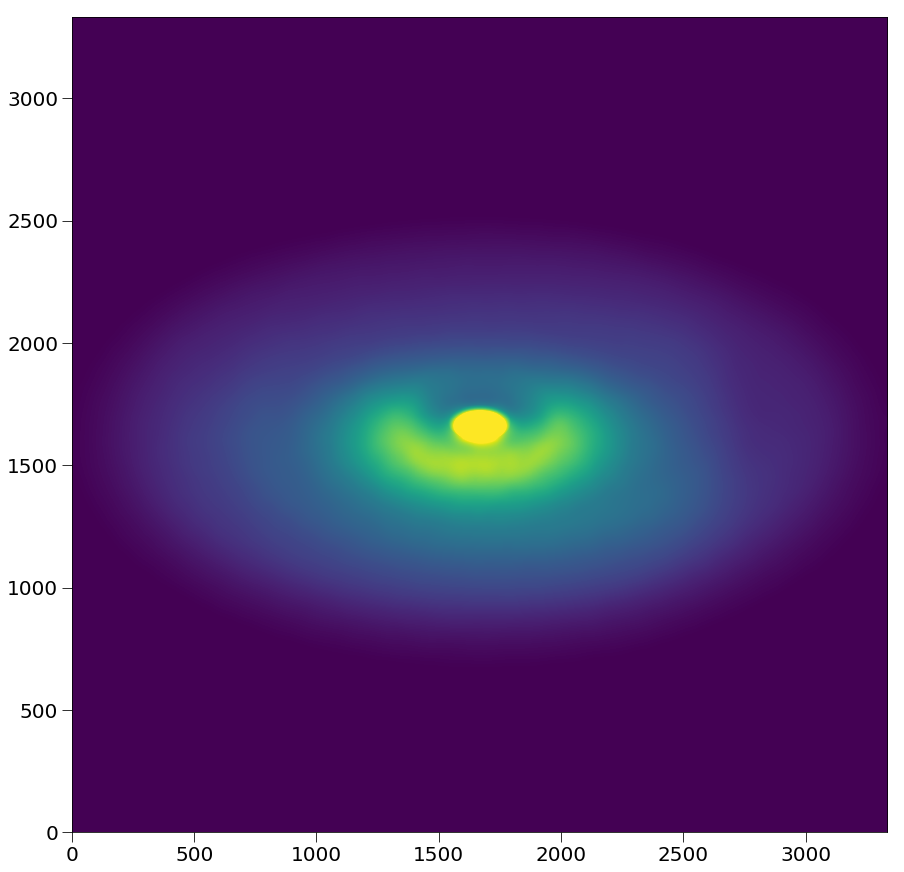

In [15]:
haystacks_file_inc60 = 'modern_cube_zodi1inc60dist10_0.70-0.87um.fits'
haystacks_inc60 = fits.open(haystacks_file_inc60)
first_slice_inc60 = haystacks_inc60[1].data
plt.figure(figsize=(15,15))
from matplotlib.colors import LogNorm
plt.imshow(first_slice_inc60,norm=LogNorm(vmin=2.2e-11,vmax=2.7e-11))

## Convert Haystacks cube to photons per second per area

In [16]:
import astropy.units as u
import astropy.constants as c

def Jy_to_photons(cube_Jy, wavel):
    '''
    Parameters
    ----------
        cube_Jy: 3D datacube in Jy
        wavel: 1D array with wavelengths in microns
    
    '''
    lamlist = (wavel*u.um).to(u.nm)
    lamcube = c.c/lamlist[:,np.newaxis,np.newaxis]**2
    
    hc = cube_Jy * u.Jansky 
    
    hc = hc.to(u.Watt/u.m**2/u.Hertz)
    hc *= lamcube
    hc = hc.to(u.W/u.m**2/u.nm)
    
    # photon energy
    Eph = (c.h*c.c/lamlist[:,np.newaxis,np.newaxis]/u.photon).to(u.J/u.photon)
    hc = (hc/Eph).to(u.photon/u.s/u.m**2/u.nm)
    
    return hc

In [17]:
haystacks_ph = Jy_to_photons(fullcube,wavlist)

In [18]:
print (haystacks_ph.unit)

ph / (m2 nm s)


## Convert Haystacks cube to photons per second per slice for a given telescope

In [39]:
dlam = (wavlist[1]-wavlist[0])*u.um
telescope_area = np.pi*(9*u.m)**2/4.
Optical_Efficiency = 0.4
Quantum_Efficiency = 0.85

haystacks_ph_per_slice = haystacks_ph*dlam.to(u.nm)*telescope_area*Optical_Efficiency*Quantum_Efficiency

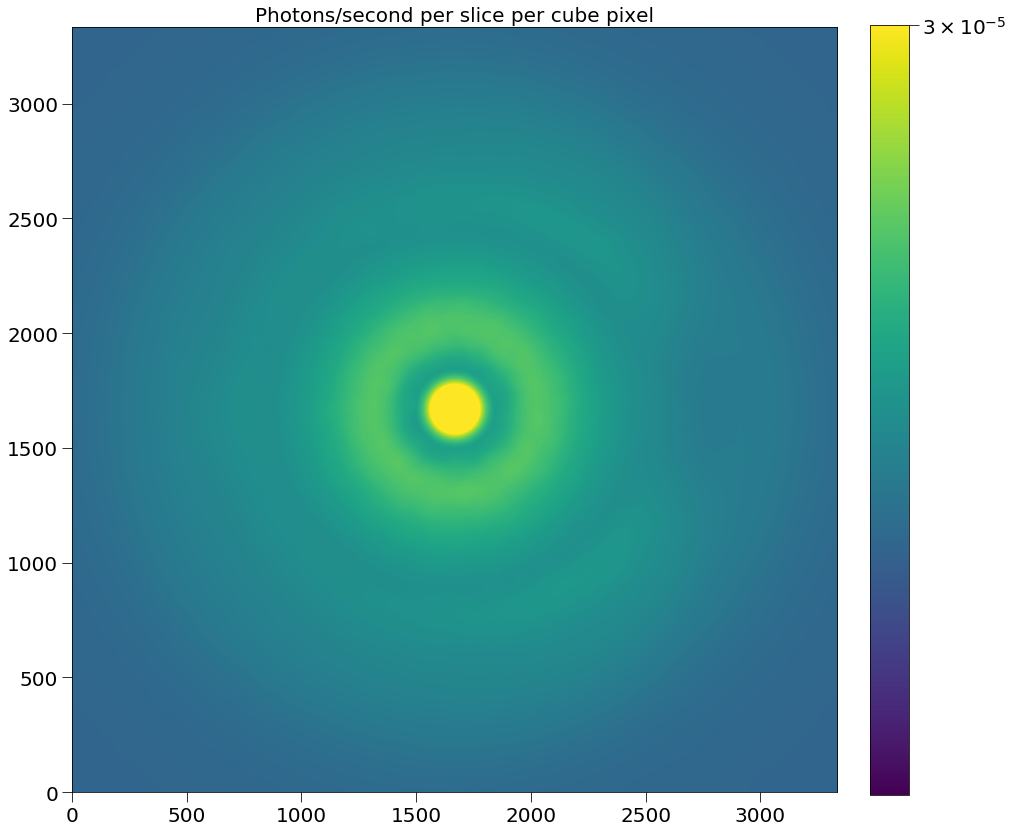

In [46]:
plt.figure(figsize=(15,15))
plt.imshow(haystacks_ph_per_slice[0].value,norm=LogNorm(vmin=2.5e-5,vmax=3e-5))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Photons/second per slice per cube pixel',fontsize=20)

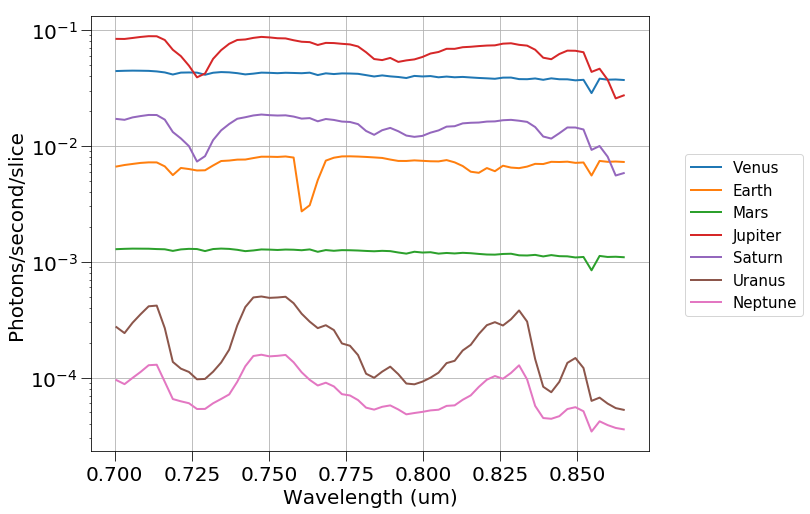

In [47]:
plt.figure(figsize=(10,8))
for p in range(planets.shape[0]):
    plt.semilogy(wavlist,haystacks_ph_per_slice[:,int(Ypix[p]),int(Xpix[p])],label=planetlist[p])
plt.xlabel('Wavelength (um)')
plt.ylabel('Photons/second/slice')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 0.70))
plt.grid()